# <center><font color="red">Pesta Data Nasional (PeDaS) 2025 - Day 02</font> <br> <font color="blue">Pendahuluan (Univariate) Time Series Forecasting</font></center>
<center><img alt="" src="images/logo-pedas.jpg" style="height: 150px;"/></center> 
<center><img alt="" src="images/head-pedas-2025.jpg"/></center> 

### <center><font color="green">Copyright ~ Taufik Sutanto 2025</font></center>

# <center><font color="blue">Outline Workshop Hari Kedua</font></center>

* Optimasi Model
* Cross Validasi Model Time Series
* Multivariate Time Series Models
* Tanya-Jawab

In [1]:
import warnings; warnings.simplefilter('ignore')
try:
    import google.colab
    IN_COLAB = True
    !mkdir data models images
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/Pedas-2025/master/data/international-airline-passengers.csv
    !pip install darts nolds tsfresh seaborn prophet plotly ipywidgets --q
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")

Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded


In [2]:
import darts, numpy as np, pandas as pd, seaborn as sns
import matplotlib, matplotlib.pyplot as plt

seed = 404
np.random.seed(seed)
"Done"

'Done'

In [3]:
from darts.datasets import AirPassengersDataset
from darts.metrics import smape, mape

# 1. Load dataset
series = AirPassengersDataset().load()

# 2. Split data menjadi train & validation
train, val = series.split_before(0.8)

# <center><font color="blue">Model (Hyperparameter) Optimization & Selection</font></center>

<center><img alt="" src="images/model_selection.png"/></center> 

<center><img alt="" src="images/hyper-tuning.jpg"/></center> 

# <center><font color="blue">Implementasi di Darts ada 3 cara:</font></center>

1. via **Optuna**: https://colab.research.google.com/github/unit8co/darts/blob/master/examples/17-hyperparameter-optimization.ipynb
2. via **Raytune**: https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html#hyperparameter-optimization-with-ray-tune
3. Klasik **GridSearch**: https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html#hyperparameter-optimization-using-gridsearch

* Pada kesempatan kali ini kita hanya akan membahas cara klasik GridSearch.
* Kemarin sebenarnya kita sudah mencoba parameter optimization, ketika menggunakan AutoArima.
* Pada kesempatan kali ini kita akan explore model time series yang lain.

# Model Theta

Model **Theta** adalah salah satu model *univariate time series forecasting* yang diperkenalkan oleh Assimakopoulos dan Nikolopoulos (2000).  
Model ini terkenal karena kesederhanaannya namun memiliki performa yang kompetitif, terutama dalam **M3 Forecasting Competition**.  

Intinya, model Theta memodifikasi kurva time series dengan mengubah parameter kelengkungan (curvature) melalui *Theta coefficient* (θ), lalu melakukan dekomposisi menjadi beberapa "Theta lines" dan menggabungkannya kembali untuk menghasilkan prediksi.

## Rumus Dasar Theta Model
Persamaan umum dari Theta model adalah:
$$
y_t^{(\theta)} = \theta \cdot y_t + (1-\theta) \cdot \hat{y}_t
$$  

di mana:  
- $y_t$ : data aktual pada waktu $t$  
- $\hat{y}_t$ : garis trend linear dari data  
- $\theta$ : parameter Theta (mengontrol kelengkungan)

Biasanya digunakan **dua nilai** θ:
- $\theta = 0$ → menghasilkan garis linear trend  
- $\theta = 2$ → menekankan variasi jangka pendek (*curvature*)  

Prediksi akhir adalah gabungan kedua garis tersebut.
<center><img alt="" src="images/Theta.gif" style="height: 250px;"/></center> 

## Kelebihan dan Keterbatasan

**Kelebihan**:
- Sederhana dan cepat dihitung  
- Performa kuat untuk banyak jenis data musiman  
- Sering digunakan sebagai *benchmark*  
 **Keterbatasan**:
- Kurang fleksibel dibandingkan model modern (Prophet, DeepAR, Transformer)  
- Hanya cocok untuk **univariate forecasting**  

**Kesimpulan**:  
Model Theta adalah metode sederhana namun efektif, terutama untuk data dengan pola musiman dan trend yang jelas.

sMAPE: 14.89%


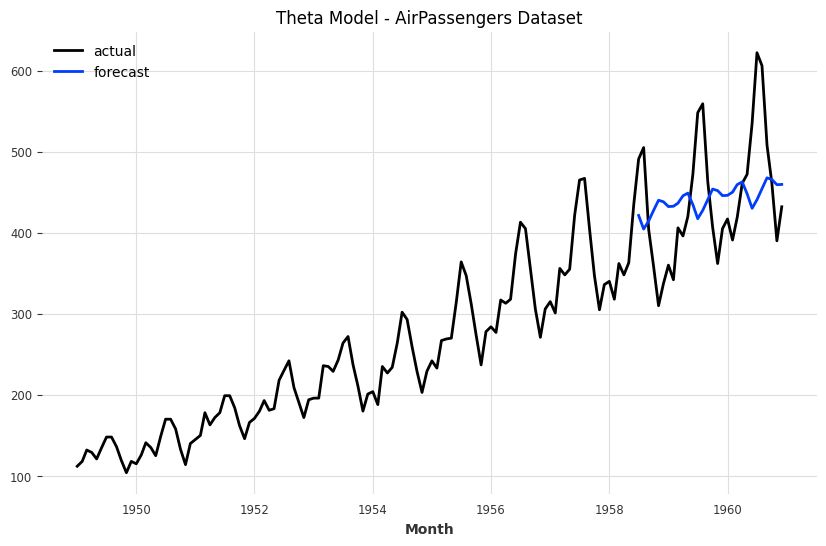

In [4]:
from darts.models import Theta

model = Theta()
model.fit(train)

# 4. Forecast
forecast = model.predict(len(val))

# 5. Evaluasi
error = smape(val, forecast)
print(f"sMAPE: {error:.2f}%")

# 6. Plot hasil
plt.figure(figsize=(10,6))
series.plot(label="actual")
forecast.plot(label="forecast")
plt.title("Theta Model - AirPassengers Dataset")
plt.legend()
plt.show()

# Optimal (Parameter) Model secara Manual

In [5]:
from tqdm import tqdm

thetas = list(range(1, 20))

best_mape = float("inf")
best_theta = 0

for theta in tqdm(thetas):
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.73it/s]


In [6]:
thetas

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [7]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(f"Lowest sMAPE is: {smape(val, pred_best_theta):.2f}, with theta = {best_theta}.")

Lowest sMAPE is: 14.90, with theta = 1.


# Saving and Loading Models


In [8]:
best_theta_model.save("models/theta.pkl")
model_loaded = Theta.load("models/theta.pkl")
"lihat file .pkl baru di Directory dimana file ipynb berada"

'lihat file .pkl baru di Directory dimana file ipynb berada'

# Prophet untuk Peramalan Deret Waktu

Prophet adalah model peramalan deret waktu yang dikembangkan oleh Facebook (Meta) yang sangat populer untuk data bisnis seperti penjualan, trafik web, atau data musiman lainnya.  
Keunggulan Prophet:  
- Mudah digunakan, hanya perlu `ds` (tanggal) dan `y` (nilai).  
- Menangani **tren**, **musiman (harian, mingguan, tahunan)**, dan **efek liburan**.  
- Mendukung data yang hilang dan outlier.  

Keunggulan utamanya adalah kemudahannya untuk digunakan bahkan oleh orang yang tidak memiliki keahlian mendalam dalam model peramalan. Prophet bersifat tangguh terhadap data yang hilang (*missing data*) dan pergeseran tren, serta biasanya dapat menangani *outlier* dengan baik.

### Kapan Sebaiknya Menggunakan Prophet?

Prophet sangat ideal untuk skenario peramalan bisnis, seperti:
- Peramalan penjualan mingguan atau bulanan.
- Memprediksi trafik website harian.
- Estimasi permintaan produk.
- Peramalan kapasitas infrastruktur.

Model ini sangat cocok untuk data yang memiliki **efek musiman yang jelas** dan **tren yang dapat berubah**. Fleksibilitasnya dalam menangani hari libur dan kemudahan interpretasi hasilnya menjadikannya pilihan populer untuk analisis deret waktu yang cepat dan andal.

### 2. Komponen Utama Model Prophet

Prophet pada dasarnya adalah model aditif yang dapat diuraikan. Artinya, ia melihat data deret waktu sebagai jumlahan dari beberapa komponen utama. Persamaan dasarnya adalah:

$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$

di mana:
- **$g(t)$**: **Tren (Trend)**. Komponen ini memodelkan perubahan non-periodik dalam data Anda. Prophet dapat secara otomatis mendeteksi titik perubahan tren.
- **$s(t)$**: **Musiman (Seasonality)**. Komponen ini menangkap perubahan periodik seperti musiman mingguan atau tahunan.
- **$h(t)$**: **Hari Libur (Holidays)**. Komponen ini memperhitungkan efek dari hari libur atau peristiwa khusus yang dapat memengaruhi data pada jadwal yang tidak teratur.
- **$\epsilon_t$**: **Error**. Ini adalah komponen sisa yang tidak dapat dijelaskan oleh model.

### 3. Visualisasi Dekomposisi Model

Salah satu fitur terbaik dari Prophet adalah kemampuannya untuk memvisualisasikan setiap komponen yang telah dimodelkan. Ini membantu kita memahami bagaimana setiap bagian berkontribusi pada hasil peramalan akhir.

Plot komponen biasanya akan menampilkan:
- **Tren**: Menunjukkan arah umum data dari waktu ke waktu.
- **Musiman Mingguan**: Menunjukkan pola perilaku data pada hari-hari yang berbeda dalam seminggu (misalnya, penjualan lebih tinggi di akhir pekan).
- **Musiman Tahunan**: Menunjukkan pola perilaku data sepanjang tahun (misalnya, penjualan es krim lebih tinggi di musim panas).


<center><img alt="" src="images/prophet.png"/></center> 

# <center><font color="blue">Implementasi Model Prophet di Darts</font></center>

* https://unit8co.github.io/darts/generated_api/darts.models.forecasting.prophet_model.html?highlight=prophet#module-darts.models.forecasting.prophet_model

17:00:53 - cmdstanpy - INFO - Chain [1] start processing
17:00:53 - cmdstanpy - INFO - Chain [1] done processing


SMAPE: 7.589575620469291


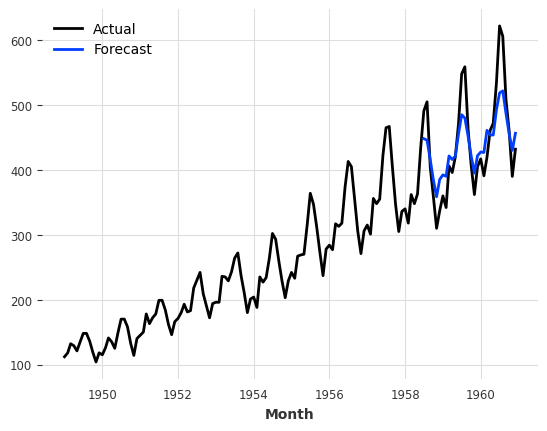

In [9]:
from darts.models import Prophet

# 3. Inisialisasi model Prophet
model = Prophet()   # bisa tambah hyperparameter, ex: Prophet(seasonality_mode="multiplicative")

# 4. Fit model ke data training
model.fit(train)

# 5. Prediksi sepanjang data validasi
forecast = model.predict(len(val))
print("SMAPE:", smape(val, forecast))

# 6. Visualisasi hasil
series.plot(label="Actual")
forecast.plot(label="Forecast")
plt.legend()
plt.show()

# Menambahkan Faktor Seasonality dan Holiday
# Additive vs Multiplicative Seasonality di Prophet

Prophet memodelkan data deret waktu sebagai kombinasi beberapa komponen:  
- $g(t)$ : tren jangka panjang (linear atau logistic growth).  
- $s(t)$ : pola musiman (harian, mingguan, tahunan) yang berulang.  
- $h(t)$ : efek liburan atau peristiwa khusus.  
- $\varepsilon_t$ : error atau noise acak.  

### Additive Seasonality  
$y(t) = g(t) + s(t) + h(t) + \varepsilon_t$

- Efek musiman **ditambahkan** ke tren.  
- Amplitudo musiman **tetap**, tidak bergantung pada level tren.  
- Contoh: setiap akhir pekan penjualan naik **+20 unit**, baik rata-rata penjualan 100 maupun 1000.  

### Multiplicative Seasonality
$y(t) = g(t) \times (1 + s(t) + h(t)) + \varepsilon_t$

- Efek musiman **dikalikan** dengan tren.  
- Amplitudo musiman **proporsional terhadap level tren**.  
- Contoh: jumlah penumpang pesawat naik **+20%** setiap bulan Juli. Jika tren naik, kenaikan absolut juga lebih besar.  

**Ringkasnya:**  
- **Additive** = musiman ditambahkan (selisih konstan).  
- **Multiplicative** = musiman dikalikan (proporsi konstan, amplitudo tumbuh seiring tren).  

<center><img alt="" src="images/additive-vs-multiplicative-prophet.jpg" style="height: 250px;"/></center> 

17:00:53 - cmdstanpy - INFO - Chain [1] start processing
17:00:53 - cmdstanpy - INFO - Chain [1] done processing


SMAPE: 3.790975648618394


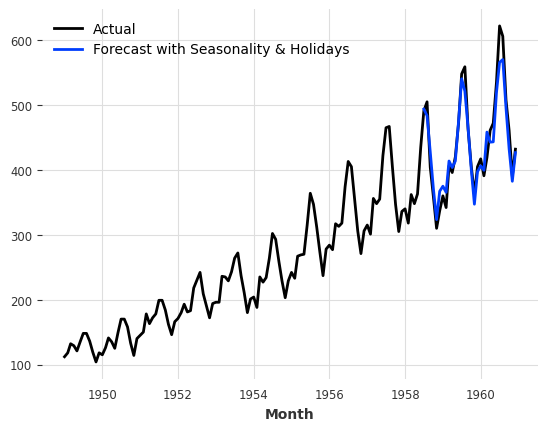

In [10]:
holidays = pd.DataFrame({
    'holiday': 'new_year',
    'ds': pd.date_range(start="1950-01-01", end="1960-01-01", freq='12MS'),  # tiap awal Januari
    'lower_window': 0,
    'upper_window': 1,
})

# 4. Inisialisasi model Prophet dengan seasonality & holiday
model = Prophet(
    seasonality_mode="multiplicative",   # default: 'additive'
    yearly_seasonality=True,             # aktifkan musiman tahunan
    weekly_seasonality=False,            # nonaktifkan musiman mingguan (karena data bulanan)
    holidays=holidays                    # tambahkan efek liburan
)

# 5. Fit model
model.fit(train)

# 6. Prediksi sepanjang data validasi
forecast = model.predict(len(val))
print("SMAPE:", smape(val, forecast))

# 7. Visualisasi hasil
series.plot(label="Actual")
forecast.plot(label="Forecast with Seasonality & Holidays")
plt.legend()
plt.show()

# <center><font color="blue">Optimasi Parameter Prophet di Darts</font></center>

* https://unit8co.github.io/darts/generated_api/darts.models.forecasting.prophet_model.html

gridsearch:   0%|          | 0/6 [00:00<?, ?it/s]

17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:55 - cmdstanpy - INFO - Chain [1] start processing
17:00:55 - cmdstanpy - INFO - Chain [1] done processing


Best Params: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'yearly_seasonality': True, 'weekly_seasonality': False}
Best MAPE: 3.4101848998650204


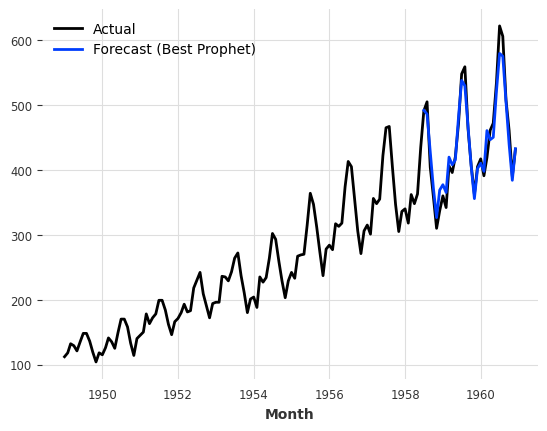

In [11]:
# !pip install darts[u] prophet

import matplotlib.pyplot as plt
from darts.datasets import AirPassengersDataset
from darts.models import Prophet
from darts.metrics import mape

# 1) Load & split
series = AirPassengersDataset().load()
train, val = series.split_before(0.8)

# 2) Grid hyperparameter Prophet
param_grid = {
    "seasonality_mode": ["additive", "multiplicative"],
    "changepoint_prior_scale": [0.01, 0.1, 0.5],
    "yearly_seasonality": [True],   # data bulanan -> aktifkan seasonality tahunan
    "weekly_seasonality": [False],  # tidak relevan untuk data bulanan
}

# 3) Grid search: PASS HANYA SATU dari {val_series | forecast_horizon | use_fitted_values}
best_model, best_params, best_score = Prophet.gridsearch(
    parameters=param_grid,
    series=train,
    val_series=val,         # gunakan validation series (JANGAN sertakan forecast_horizon / use_fitted_values)
    metric=mape,
    verbose=True
)

print("Best Params:", best_params)
print("Best MAPE:", best_score)

# 4) Forecast & plot
best_model.fit(train)
forecast = best_model.predict(len(val))
series.plot(label="Actual")
forecast.plot(label="Forecast (Best Prophet)")
plt.legend()
plt.show()

# Cross Validasi di Time Series:
# **Pengujian Ulang (*Backtesting*): Simulasi Peramalan Historis**  
Saat ini, kita memiliki model yang berkinerja baik pada set validasi, dan itu merupakan hasil yang baik. Namun, bagaimana kita dapat mengetahui kinerja yang mungkin kita peroleh jika kita telah menggunakan model ini secara historis?

*Backtesting* mensimulasikan prediksi yang akan diperoleh secara historis dengan model tertentu. Proses ini dapat memakan waktu, karena model (secara default) dilatih ulang setiap kali waktu prediksi simulasi maju.

Prediksi simulasi semacam ini selalu didefinisikan dalam kaitannya dengan *forecast horizon*, yaitu jumlah langkah waktu yang memisahkan waktu prediksi dari waktu peramalan. Dalam contoh berikut, kita mensimulasikan peramalan untuk 3 bulan ke depan (dibandingkan dengan waktu prediksi). Hasil dari pemanggilan fungsi `historical_forecasts()` (secara default) adalah sebuah *TimeSeries* yang hanya berisi nilai prediksi terakhir dari masing-masing peramalan untuk 3 bulan ke depan tersebut.

<center><img alt="" src="images/timeSeries-CV.png"/></center>
<center><img alt="" src="images/timeseries-cv-shift.gif"/></center>

In [16]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("1956-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}

Membuat dictionary parameter untuk fungsi historical_forecasts:

* series → data time series yang mau diprediksi.
* start → menentukan titik waktu kapan backtest mulai dilakukan (di sini mulai dari 1956-01-01). Bisa juga float (misal 0.7) artinya mulai dari 70% panjang seri.
* forecast_horizon → berapa langkah ke depan yang diprediksi setiap kali (di sini 3 bulan ke depan).
* verbose=True → tampilkan log saat proses jalan.

In [17]:
historical_fcast_theta = best_theta_model.historical_forecasts(last_points_only=True, **hfc_params)

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

## Menjalankan backtesting:

* Model best_theta_model (model Theta terbaik hasil tuning sebelumnya) dipakai untuk membuat prediksi.
* historical_forecasts = teknik evaluasi di mana kita mensimulasikan seolah-olah kita melakukan prediksi dari masa lalu berkali-kali.
* last_points_only=True artinya kita hanya simpan titik prediksi terakhir dari setiap iterasi, bukan seluruh horizon.

In [ ]:
series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print(f"sMAPE = {smape(series, historical_fcast_theta):.2f}%")

In [18]:
hfc_precomputed = best_theta_model.historical_forecasts(last_points_only=False, stride=1, **hfc_params)

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

Average error (sMAPE) over all historical forecasts: 6.40


* historical_forecasts = menghasilkan prediksi historis dari model pada setiap titik waktu di sepanjang data.
* last_points_only=False = menyimpan seluruh hasil prediksi, bukan hanya prediksi terakhir.
* stride=1 = model membuat prediksi pada setiap langkah waktu (tanpa melompati titik).
* **hfc_params = parameter tambahan (misalnya forecast_horizon=3, start, dsb. yang sudah didefinisikan sebelumnya).
* Output hfc_precomputed berisi semua prediksi historis yang dihitung di muka (precomputed).

In [20]:
hfc_precomputed

[<TimeSeries (Month: 3, component: 1, sample: 1)> Size: 24B
 array([[[279.58242957]],
 
        [[280.51378975]],
 
        [[319.67834453]]])
 Coordinates:
   * Month      (Month) datetime64[ns] 24B 1956-01-01 1956-02-01 1956-03-01
   * component  (component) object 8B '#Passengers'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None
     metadata:           None,
 <TimeSeries (Month: 3, component: 1, sample: 1)> Size: 24B
 array([[[284.28640203]],
 
        [[323.97767843]],
 
        [[309.17300648]]])
 Coordinates:
   * Month      (Month) datetime64[ns] 24B 1956-02-01 1956-03-01 1956-04-01
   * component  (component) object 8B '#Passengers'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None
     metadata:           None,
 <TimeSeries (Month: 3, component: 1, sample: 1)> Size: 24B
 array([[[318.08212831]],
 
        [[303.54686284]],
 
        [[297.71214836]]])

In [19]:
new_error = best_theta_model.backtest(historical_forecasts=hfc_precomputed, last_points_only=False, stride=1, **hfc_params)
print(f"Average error (sMAPE) over all historical forecasts: {new_error:.2f}")

Average error (sMAPE) over all historical forecasts: 6.40


* backtest() = menghitung error metrik (default: sMAPE) antara hasil forecasting dan data aktual.
* historical_forecasts=hfc_precomputed = menggunakan prediksi historis yang sudah dihitung sebelumnya (menghemat waktu).
* last_points_only=False & stride=1 = sama seperti sebelumnya, evaluasi di semua titik.
* Output new_error adalah rata-rata error (sMAPE) dari semua prediksi histori

In [21]:
best_theta_model = Theta(best_theta)
raw_errors = best_theta_model.backtest(metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params)

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

* backtest = fungsi untuk mengevaluasi model dengan melakukan forecasting ke masa lalu (simulasi seolah-olah kita memprediksi data yang sebenarnya sudah ada).

Parameter penting:
* metric=mape: menggunakan Mean Absolute Percentage Error sebagai ukuran error.
* reduction=None: artinya kita tidak merata-ratakan hasil error, tetapi menyimpan semua nilai error individual untuk setiap langkah peramalan.
* last_points_only=False: menyimpan semua prediksi, bukan hanya titik terakhir.
* stride=1: setiap 1 langkah ke depan akan dihitung.
* **hfc_params: parameter tambahan seperti panjang horizon forecast (forecast_horizon=3) dan titik awal backtest.
* Output: raw_errors berupa list/array error individual dari setiap percobaan forecast di masa lalu.

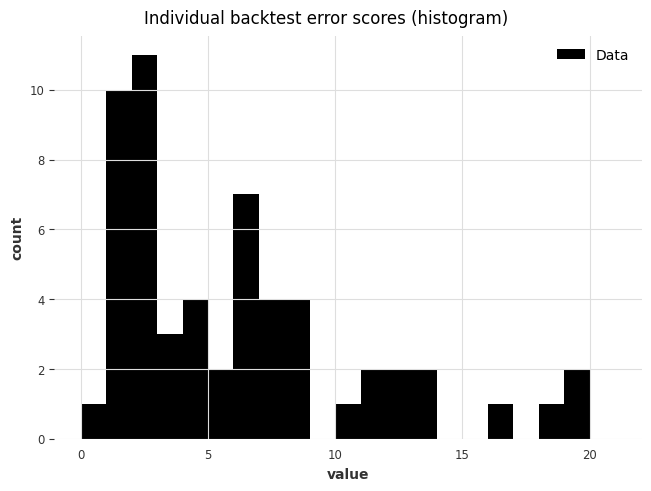

In [23]:
from darts.utils.statistics import plot_hist

plot_hist(raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",)
plt.show()

# Interpretasi Hasil

* Jika histogram condong ke kiri (kebanyakan error kecil): Model stabil dan sering menghasilkan prediksi yang akurat.
* Jika histogram tersebar lebar / banyak error besar: Model kurang konsisten, kadang bisa sangat akurat tapi juga kadang meleset jauh.

## Puncak histogram (mode):
* Menunjukkan error yang paling sering terjadi. Misalnya jika banyak error < 5%, berarti sebagian besar prediksi bagus.

## Ekor panjang (long tail):
* Jika ada error tinggi yang jarang muncul → bisa jadi data anomali atau model kesulitan pada kondisi tertentu (misalnya saat ada perubahan tren drastis).

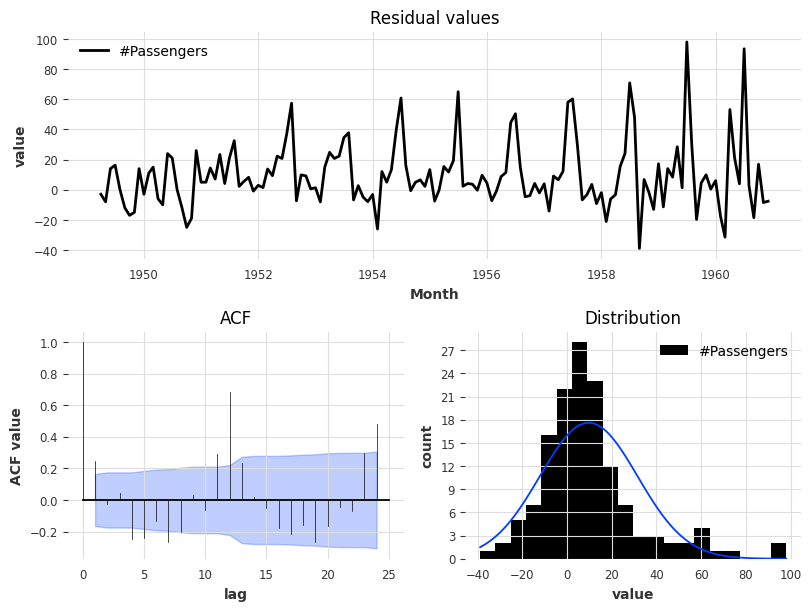

In [24]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))
plt.show()

## Interpretasi hasil yang bisa didapat:

* Jika residuals menyebar acak (white noise): Model cukup baik karena tidak ada pola yang tersisa dalam error.
* Jika ada autokorelasi signifikan pada residual: Berarti model belum menangkap pola tertentu dalam data → mungkin perlu model lain atau penyesuaian hyperparameter.
* Jika histogram residuals jauh dari normal: Mengindikasikan prediksi model bias pada beberapa nilai.
* Jika residuals cenderung naik/turun seiring waktu: Model mungkin underfitting (tidak cukup kompleks) atau ada tren musiman yang belum ditangkap.

# Expanding window vs Sliding window

Default Darts untuk historical_forecasts() adalah expanding window:

* Setelah setiap langkah forecast, data historis yang dipakai untuk melatih model akan bertambah dengan titik-titik baru.
* Model biasanya dilatih ulang di tiap iterasi (retrain=True, default).
* Window makin lama makin besar → expanding.

Sliding Window Backtest MAPE: 6.54


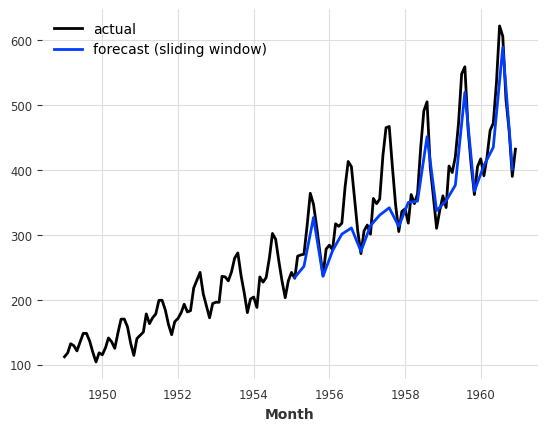

In [27]:
# Import library
import matplotlib.pyplot as plt
from darts.datasets import AirPassengersDataset
from darts.models import Theta
from darts.metrics import mape

# --- 1. Load data ---
series = AirPassengersDataset().load()

# --- 2. Buat model Theta ---
best_theta_model = Theta()

# --- 3. Parameter untuk historical_forecasts (sliding window) ---
hfc_params = dict(
    start=0.5,             # mulai backtesting dari 50% panjang data
    forecast_horizon=3,    # prediksi 3 langkah ke depan
    stride=3,              # geser jendela tiap 3 langkah
    retrain=True,          # retrain model tiap window
    last_points_only=True  # ambil hanya titik terakhir tiap window
)

# --- 4. Sliding window historical forecasts ---
historical_fcast_theta = best_theta_model.historical_forecasts(
    series,
    **hfc_params
)

# --- 5. Hitung error sliding window ---
error = mape(series, historical_fcast_theta)
print(f"Sliding Window Backtest MAPE: {error:.2f}")

# --- 6. Plot hasil ---
series.plot(label="actual")
historical_fcast_theta.plot(label="forecast (sliding window)")
plt.legend()
plt.show() 

## Sliding Window vs Expanding Window dalam Time Series Forecasting

### 1. Expanding Window
**Konsep:**  
- Mulai dari subset awal data.  
- Setiap iterasi, window **bertambah panjang** dengan data baru.  
- Model biasanya **dilatih ulang** di setiap window.

**Kelebihan:**  
- Menggunakan sebanyak mungkin data → prediksi lebih stabil dan akurat.  
- Cocok untuk data **stasioner atau semi-stasioner**.

**Kapan digunakan:**  
- Data historis banyak dan relevan untuk prediksi masa depan.  
- Model mampu menangani dataset besar tanpa masalah komputasi.  
- Tujuan: memaksimalkan akurasi dengan memanfaatkan seluruh data yang tersedia.

### 2. Sliding Window
**Konsep:**  
- Window memiliki **panjang tetap**.  
- Setelah setiap prediksi, window **digeser** ke depan.  
- Model dilatih ulang (atau tidak) hanya pada window saat ini → data lama di luar window diabaikan.

**Kelebihan:**  
- Fokus pada **data terbaru** → cocok jika pola/tren berubah seiring waktu.  
- Mengurangi beban komputasi karena tidak menggunakan seluruh data lama.

**Kapan digunakan:**  
- Data **non-stasioner**, dengan tren atau musiman yang berubah.  
- Dataset sangat besar → ingin mengurangi waktu training model.  
- Tujuan: memprediksi berdasarkan **informasi terbaru** dan menghindari “membebani” model dengan data lama yang tidak relevan.

### 3. Perbandingan Ringkas

| Aspek                 | Expanding Window                     | Sliding Window                       |
|-----------------------|------------------------------------|------------------------------------|
| Panjang window        | Bertambah terus                     | Tetap                              |
| Fokus data            | Semua data historis                 | Data terbaru (fixed-length)        |
| Komputasi             | Lebih berat                         | Lebih ringan                        |
| Cocok untuk           | Data stabil / stasioner             | Data non-stasioner / tren berubah  |
| Prediksi              | Lebih akurat jika data relevan      | Lebih adaptif terhadap perubahan   |


💡 **Intinya:**  
- Gunakan **expanding window** jika data lama tetap relevan.  
- Gunakan **sliding window** jika pola lama sudah tidak relevan dan tren berubah seiring waktu.


# <center>Univariate VS Multivariate VS Multiple Time Series</center>

* https://unit8co.github.io/darts/userguide/timeseries.html#multivariate-time-series-vs-multiple-time-series

### **Pembedaan antara Deret Univariat dan Multivariat**  

1. **Deret Multivariat**  
   - Berisi banyak dimensi (yakni, beberapa nilai untuk setiap langkah waktu).  
   - Semua komponen dalam deret multivariat berbagi sumbu waktu yang sama, yaitu memiliki stempel waktu yang sama.  

2. **Deret Univariat**  
   - Berisi hanya satu dimensi (yakni, satu nilai skalar untuk setiap langkah waktu).  
   - Dalam konteks objek **TimeSeries**, deret ini hanya memiliki satu komponen.  

### Komponen dalam Deret Waktu  
- Dimensi dalam deret waktu sering disebut **komponen**.  
- **TimeSeries** dapat berupa:  
  - Univariat (satu komponen).  
  - Multivariat (beberapa komponen).  

### Dukungan Model dalam Darts
1. **Model Multivariat**  
   - Beberapa model dalam Darts (termasuk semua model berbasis *machine learning*) mendukung deret multivariat.  
   - Model ini dapat menerima deret multivariat sebagai masukan (baik sebagai target maupun *covariates*), dan prediksi yang dihasilkan akan memiliki dimensi yang sesuai dengan target.  

2. **Model dengan Panel Data**  
   - Beberapa model dapat bekerja dengan beberapa deret waktu sekaligus (*multiple TimeSeries objects*).  
   - Dalam kasus ini:  
     - Deret waktu yang berbeda tidak harus memiliki indeks waktu yang sama.  
     - Frekuensi antar deret waktu juga tidak harus sama.  
   - Model ini memerlukan input berupa urutan Python (*Python Sequences*) dari objek **TimeSeries** (misalnya, daftar sederhana dari beberapa **TimeSeries**).  

Pendekatan ini sangat fleksibel dan memungkinkan analisis data panel, seperti deret waktu dari periode atau lokasi yang berbeda, dengan tetap menjaga efisiensi model.

<center><img alt="" src="images/univariate-multivariate-multiple-timeseries.png"/></center>

### **Contoh Deret Multivariat:**  
Tekanan darah dan detak jantung dari satu pasien yang diukur sepanjang waktu. Dalam kasus ini:  
- **Deret waktu multivariat** memiliki **2 komponen**: tekanan darah dan detak jantung.  
- Semua pengamatan memiliki stempel waktu yang sama untuk pasien tersebut.

**Contoh Banyak Deret Waktu (multiple):**  
Tekanan darah dan detak jantung dari beberapa pasien yang mungkin diukur pada waktu yang berbeda untuk setiap pasien. Dalam kasus ini:  
- Setiap pasien memiliki **satu deret waktu multivariat** dengan **2 komponen**: tekanan darah dan detak jantung.  
- Waktu pengamatan antar pasien tidak harus sama, dan frekuensinya juga dapat berbeda.  

### Perbedaan Utama  
- **Deret Multivariat:** Semua data berbagi sumbu waktu yang sama.  
- **Banyak Deret Waktu (multiple):** Terdiri dari beberapa deret waktu, di mana masing-masing deret dapat memiliki indeks waktu atau frekuensi yang berbeda.  

Pendekatan ini memungkinkan fleksibilitas dalam menganalisis data individu maupun kelompok dalam berbagai konteks medis atau lainnya.

# Contoh implementasi Multivariate Time Series di Darts

* https://unit8co.github.io/darts/userguide/forecasting_overview.html#support-for-multivariate-series

